# Классификация знаков Дорожного Движения

In [1]:
# !pip install natsort

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from skimage import transform

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.compat.v1.config.experimental.list_physical_devices("GPU") else "OFF" }')


import numpy as np
import matplotlib, random
import matplotlib.pyplot as plt
import pandas as pd 
import cv2
import os

from imutils import paths
import os
import pathlib
import LRFinder
from natsort import natsorted

Tensorflow version 2.10.0
GPU is ON


In [3]:
data = []
labels = []
sumu =0
start = 0
input_size = (120,80)
path = "./New_Dataset/service_signs/"
num_classes = len(os.listdir(path))
for file_number in os.listdir(path):
    path2 = str(path+file_number)
    num = 0
    count=0
    for file_number_2 in os.listdir(path2):
        path3 = str(path2 + '/' + file_number_2)
#         if count == 320: break
        count = count+1
        imagepath = (path3)
#         print(imagepath)
        image = cv2.imread(imagepath, 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image = transform.resize(image, input_size)
        data.append(image)

        label = file_number
        labels.append(label)
    num = num + count
    sumu = sumu+count
    print(label, num)
print('all',sumu)

165 209
166 173
167 245
168 245
169 209
170 209
171 209
172 209
173 173
174 173
175 281
176 281
177 173
178 209
179 173
180 173
181 209
182 245
all 3798


In [4]:
df = pd.DataFrame({'labels': labels})
print(df.nunique())
print(df['labels'].value_counts())

labels    18
dtype: int64
175    281
176    281
182    245
167    245
168    245
181    209
178    209
165    209
172    209
171    209
170    209
169    209
173    173
166    173
177    173
179    173
180    173
174    173
Name: labels, dtype: int64


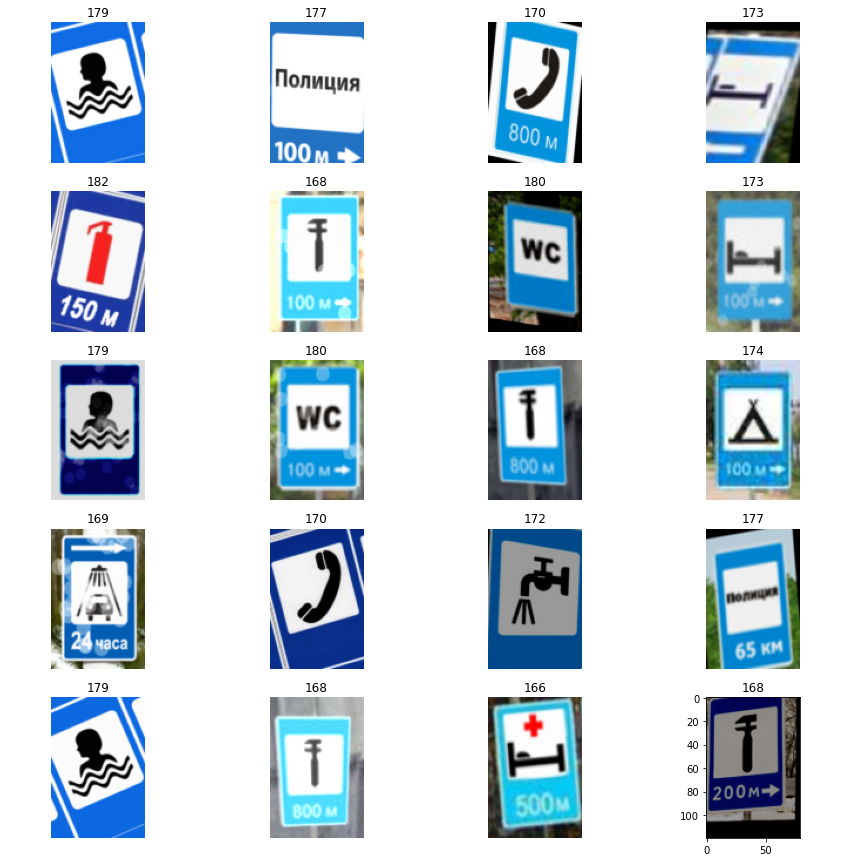

In [5]:
fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    z = random.randint(1,len(labels))
    plt.axis('off') 
    fig.add_subplot(rows, columns, i)
    plt.title(labels[z])
    plt.imshow(data[z])
plt.show()

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state = 42, test_size = 0.3, stratify = labels)

from keras.utils import to_categorical
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [18]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D,UpSampling2D,ZeroPadding2D, Dense, Flatten, Dropout, BatchNormalization , Input, ReLU
from keras import initializers
import math
import tensorflow_addons as tfa

from keras.optimizers import SGD, Adam

opt = SGD(learning_rate=0.008)
# opt = Adam(learning_rate=0.0001)
# opt = SGD()
initializer = initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512), seed=42)

model = Sequential()
model.add(Input(shape=np.array(X_train).shape[1:]))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=32, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.05))

model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=64, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.1))

# model.add(ZeroPadding2D(padding=1))
model.add(Conv2D(filters=128, kernel_size=3, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.15))

# model.add(ZeroPadding2D(padding=2))
model.add(Conv2D(filters=256, kernel_size=5, activation = 'swish'))
# model.add(ReLU())

model.add(MaxPool2D(pool_size=2))
model.add(Dropout(rate=0.2))

model.add(BatchNormalization (momentum=0.9, epsilon=1e-5))


model.add(Flatten()) # по кол-ву пикселей из 2д в 1д
model.add(Dense(128, activation='swish')) # кол-во нейронов в слое
model.add(Dense(64, activation='swish')) # кол-во нейронов в слое
model.add(Dense(32, activation='swish')) # кол-во нейронов в слое
model.add(Dense(num_classes, kernel_initializer=initializer, bias_initializer=initializer, activation='softmax'))  # кол-во нейронов на выходе, по кол-ву классов


model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=tfa.metrics.F1Score(num_classes=num_classes))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 118, 78, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 39, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 59, 39, 32)        0         
                                                                 
 zero_padding2d_4 (ZeroPaddi  (None, 61, 41, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_5 (Conv2D)           (None, 59, 39, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 19, 64)      

In [19]:
# lr_finder = LRFinder.LRFinder(model)
# lr_finder.find(np.array(X_train), np.array(y_train), start_lr=0.00001, end_lr=1, batch_size=10, epochs=20)
# lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [20]:
history = model.fit(np.array(X_train), np.array(y_train), batch_size=10, epochs=50, validation_data=(np.array(X_test), np.array(y_test)))

Epoch 1/50
266/266 [==============================] - 7s 21ms/step - loss: 2.7466 - f1_score: 0.0730 - val_loss: 2.4048 - val_f1_score: 0.1933
Epoch 2/50
266/266 [==============================] - 5s 20ms/step - loss: 1.7340 - f1_score: 0.4313 - val_loss: 1.0611 - val_f1_score: 0.6946
Epoch 3/50
266/266 [==============================] - 5s 20ms/step - loss: 0.7997 - f1_score: 0.7696 - val_loss: 0.4860 - val_f1_score: 0.8490
Epoch 4/50
266/266 [==============================] - 5s 19ms/step - loss: 0.4314 - f1_score: 0.8729 - val_loss: 0.2710 - val_f1_score: 0.9116
Epoch 5/50
266/266 [==============================] - 5s 19ms/step - loss: 0.2399 - f1_score: 0.9345 - val_loss: 0.1949 - val_f1_score: 0.9421
Epoch 6/50
266/266 [==============================] - 5s 20ms/step - loss: 0.1672 - f1_score: 0.9591 - val_loss: 0.1278 - val_f1_score: 0.9609
Epoch 7/50
266/266 [==============================] - 5s 20ms/step - loss: 0.1161 - f1_score: 0.9697 - val_loss: 0.0948 - val_f1_score: 0.9727

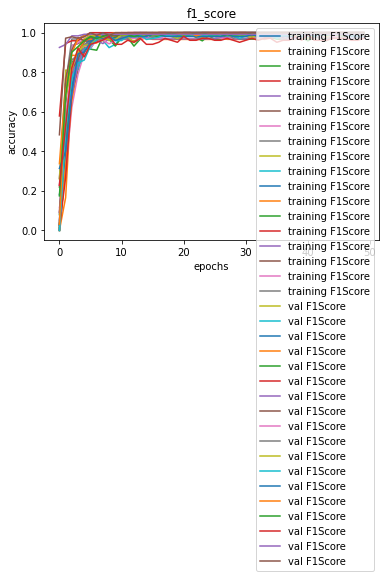

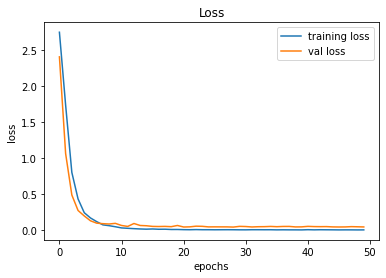

In [21]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['f1_score'], label='training F1Score')
plt.plot(history.history['val_f1_score'], label='val F1Score')
plt.title('f1_score')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [22]:
# model.save('./saved_models/Trafic_Signs_CNN_service_signs(80x120).h5')

In [23]:
service_signs_classes = {'0':165,
'1':166,
'2':167,
'3':168,
'4':169,
'5':170,
'6':171,
'7':172,
'8':173,
'9':174,
'10':175,
'11':176,
'12':177,
'13':178,
'14':179,
'15':180,
'16':181,
'17':182,}

In [24]:
from sklearn.metrics import f1_score
df = pd.read_csv('./Data_images/Test_data.csv')
all_classes = []
predicted_classes = []

for c in range (165,182):
    for i in range(len(df.loc[df['ClassId'] == c]) ):
        
        all_classes.append(c)
        # Считываем тестовый датасет
        image_path = df.loc[df['ClassId'] == c].values[i][1]
        classid = df.loc[df['ClassId'] == c].values[i][0]
        
        # Обрабатываем изображения
        image = cv2.imread(str('./Data_images/' + str(image_path)), 1) ## Считываем изображение
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) ## переводим в оттенки серого
        image_resized = transform.resize(image, input_size)
        img_batch = np.expand_dims(image_resized,0)
        
        # Начинаем предсказание категории знака
        prediction = model.predict(img_batch)
        prediction = np.argmax(prediction, axis=1)
        predicted_classes.append(service_signs_classes[str(prediction[0])])
        
        if classid != service_signs_classes[(str(prediction[0]))]:
             print(classid,service_signs_classes[(str(prediction[0]))], prediction[0], image_path)


1/1 [==============================] - 0s 17ms/step
165 176 11 Test/165_3_32.png
1/1 [==============================] - 0s 18ms/step
165 182 17 Test/165_7_24.png
1/1 [==============================] - 0s 19ms/step
165 166 1 Test/165_4_16.png
1/1 [==============================] - 0s 16ms/step
165 172 7 Test/165_5_30.png
1/1 [==============================] - 0s 18ms/step
165 176 11 Test/165_5_8.png
1/1 [==============================] - 0s 17ms/step
165 171 6 Test/165_5_2.png
1/1 [==============================] - 0s 17ms/step
165 176 11 Test/165_5_5.png
1/1 [==============================] - 0s 16ms/step
165 173 8 Test/165_2_21.png
1/1 [==============================] - 0s 31ms/step
165 176 11 Test/165_3_11.png
1/1 [==============================] - 0s 16ms/step
165 171 6 Test/165_5_3.png
1/1 [==============================] - 0s 16ms/step
165 173 8 Test/165_1_18.png
1/1 [==============================] - 0s 16ms/step
165 176 11 Test/165_5_24.png
1/1 [==============================] -

1/1 [==============================] - 0s 25ms/step
166 176 11 Test/166_3_25.png
1/1 [==============================] - 0s 15ms/step
166 176 11 Test/166_3_22.png
1/1 [==============================] - 0s 16ms/step
166 165 0 Test/166_5_21.png
1/1 [==============================] - 0s 16ms/step
166 176 11 Test/166_4_18.png
1/1 [==============================] - 0s 17ms/step
166 173 8 Test/166_6_25.png
1/1 [==============================] - 0s 8ms/step
166 176 11 Test/166_3_16.png
1/1 [==============================] - 0s 17ms/step
166 176 11 Test/166_4_13.png
1/1 [==============================] - 0s 16ms/step
166 173 8 Test/166_6_24.png
1/1 [==============================] - 0s 17ms/step
166 170 5 Test/166_6_10.png
1/1 [==============================] - 0s 9ms/step
166 176 11 Test/166_3_20.png
1/1 [==============================] - 0s 17ms/step
166 176 11 Test/166_3_4.png
1/1 [==============================] - 0s 17ms/step
166 176 11 Test/166_4_10.png
1/1 [==============================

1/1 [==============================] - 0s 17ms/step
167 176 11 Test/167_3_21.png
1/1 [==============================] - 0s 11ms/step
167 178 13 Test/167_3_26.png
1/1 [==============================] - 0s 10ms/step
167 176 11 Test/167_3_18.png
1/1 [==============================] - 0s 17ms/step
167 165 0 Test/167_3_25.png
1/1 [==============================] - 0s 13ms/step
167 172 7 Test/167_3_16.png
1/1 [==============================] - 0s 16ms/step
167 176 11 Test/167_3_22.png
1/1 [==============================] - 0s 11ms/step
168 172 7 Test/168_7_24.png
1/1 [==============================] - 0s 12ms/step
168 172 7 Test/168_7_26.png
1/1 [==============================] - 0s 13ms/step
168 171 6 Test/168_7_13.png
1/1 [==============================] - 0s 16ms/step
168 171 6 Test/168_7_9.png
1/1 [==============================] - 0s 17ms/step
168 172 7 Test/168_7_11.png
1/1 [==============================] - 0s 16ms/step
168 175 10 Test/168_2_17.png
1/1 [==============================]

1/1 [==============================] - 0s 15ms/step
168 171 6 Test/168_7_30.png
1/1 [==============================] - 0s 15ms/step
168 172 7 Test/168_7_18.png
1/1 [==============================] - 0s 17ms/step
168 175 10 Test/168_6_35.png
1/1 [==============================] - 0s 16ms/step
168 165 0 Test/168_3_26.png
1/1 [==============================] - 0s 13ms/step
168 172 7 Test/168_7_37.png
1/1 [==============================] - 0s 9ms/step
168 172 7 Test/168_7_0.png
1/1 [==============================] - 0s 16ms/step
168 173 8 Test/168_5_17.png
1/1 [==============================] - 0s 10ms/step
168 171 6 Test/168_4_17.png
1/1 [==============================] - 0s 16ms/step
168 176 11 Test/168_7_35.png
1/1 [==============================] - 0s 9ms/step
168 176 11 Test/168_7_33.png
1/1 [==============================] - 0s 30ms/step
168 172 7 Test/168_7_38.png
1/1 [==============================] - 0s 21ms/step
168 172 7 Test/168_7_2.png
1/1 [==============================] - 0s

1/1 [==============================] - 0s 20ms/step
169 174 9 Test/169_5_28.png
1/1 [==============================] - 0s 17ms/step
169 174 9 Test/169_2_18.png
1/1 [==============================] - 0s 13ms/step
169 174 9 Test/169_1_27.png
1/1 [==============================] - 0s 17ms/step
170 173 8 Test/170_1_25.png
1/1 [==============================] - 0s 17ms/step
170 175 10 Test/170_4_21.png
1/1 [==============================] - 0s 16ms/step
170 172 7 Test/170_5_0.png
1/1 [==============================] - 0s 16ms/step
170 167 2 Test/170_4_16.png
1/1 [==============================] - 0s 16ms/step
170 166 1 Test/170_5_20.png
1/1 [==============================] - 0s 13ms/step
170 173 8 Test/170_1_12.png
1/1 [==============================] - 0s 17ms/step
170 171 6 Test/170_5_30.png
1/1 [==============================] - 0s 17ms/step
170 173 8 Test/170_3_28.png
1/1 [==============================] - 0s 17ms/step
170 167 2 Test/170_4_20.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step
170 173 8 Test/170_2_19.png
1/1 [==============================] - 0s 11ms/step
170 181 16 Test/170_4_17.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_19.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_0.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_11.png
1/1 [==============================] - 0s 18ms/step
171 176 11 Test/171_2_12.png
1/1 [==============================] - 0s 10ms/step
171 165 0 Test/171_2_16.png
1/1 [==============================] - 0s 11ms/step
171 170 5 Test/171_4_26.png
1/1 [==============================] - 0s 18ms/step
171 165 0 Test/171_2_5.png
1/1 [==============================] - 0s 9ms/step
171 172 7 Test/171_5_13.png
1/1 [==============================] - 0s 13ms/step
171 165 0 Test/171_2_20.png
1/1 [==============================] - 0s 18ms/step
171 165 0 Test/171_6_17.png
1/1 [==============================] - 0s

1/1 [==============================] - 0s 13ms/step
171 174 9 Test/171_4_16.png
1/1 [==============================] - 0s 16ms/step
171 176 11 Test/171_4_20.png
1/1 [==============================] - 0s 14ms/step
171 165 0 Test/171_2_4.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_32.png
1/1 [==============================] - 0s 17ms/step
171 168 3 Test/171_3_20.png
1/1 [==============================] - 0s 15ms/step
171 176 11 Test/171_7_35.png
1/1 [==============================] - 0s 16ms/step
171 165 0 Test/171_2_8.png
1/1 [==============================] - 0s 13ms/step
171 165 0 Test/171_2_3.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_17.png
1/1 [==============================] - 0s 17ms/step
171 165 0 Test/171_2_18.png
1/1 [==============================] - 0s 17ms/step
171 172 7 Test/171_2_21.png
1/1 [==============================] - 0s 16ms/step
172 176 11 Test/172_6_20.png
1/1 [==============================] - 0

1/1 [==============================] - 0s 17ms/step
172 176 11 Test/172_6_22.png
1/1 [==============================] - 0s 16ms/step
172 176 11 Test/172_6_19.png
1/1 [==============================] - 0s 17ms/step
172 173 8 Test/172_6_9.png
1/1 [==============================] - 0s 17ms/step
172 168 3 Test/172_6_17.png
1/1 [==============================] - 0s 17ms/step
172 176 11 Test/172_6_36.png
1/1 [==============================] - 0s 14ms/step
172 176 11 Test/172_3_6.png
1/1 [==============================] - 0s 17ms/step
172 176 11 Test/172_6_24.png
1/1 [==============================] - 0s 17ms/step
172 176 11 Test/172_6_21.png
1/1 [==============================] - 0s 17ms/step
172 178 13 Test/172_4_19.png
1/1 [==============================] - 0s 8ms/step
172 166 1 Test/172_6_16.png
1/1 [==============================] - 0s 20ms/step
172 176 11 Test/172_6_26.png
1/1 [==============================] - 0s 18ms/step
172 176 11 Test/172_6_28.png
1/1 [=============================

1/1 [==============================] - 0s 17ms/step
173 170 5 Test/173_5_14.png
1/1 [==============================] - 0s 17ms/step
173 176 11 Test/173_1_19.png
1/1 [==============================] - 0s 18ms/step
173 174 9 Test/173_2_24.png
1/1 [==============================] - 0s 16ms/step
173 176 11 Test/173_6_22.png
1/1 [==============================] - 0s 15ms/step
173 172 7 Test/173_1_9.png
1/1 [==============================] - 0s 18ms/step
173 166 1 Test/173_1_11.png
1/1 [==============================] - 0s 17ms/step
173 176 11 Test/173_1_20.png
1/1 [==============================] - 0s 17ms/step
173 176 11 Test/173_2_21.png
1/1 [==============================] - 0s 16ms/step
173 167 2 Test/173_4_17.png
1/1 [==============================] - 0s 16ms/step
174 175 10 Test/174_4_26.png
1/1 [==============================] - 0s 16ms/step
174 175 10 Test/174_1_16.png
1/1 [==============================] - 0s 16ms/step
174 168 3 Test/174_4_22.png
1/1 [==============================

1/1 [==============================] - 0s 16ms/step
174 172 7 Test/174_4_18.png
1/1 [==============================] - 0s 13ms/step
174 175 10 Test/174_2_29.png
1/1 [==============================] - 0s 16ms/step
174 175 10 Test/174_4_25.png
1/1 [==============================] - 0s 15ms/step
174 175 10 Test/174_3_30.png
1/1 [==============================] - 0s 16ms/step
174 170 5 Test/174_3_25.png
1/1 [==============================] - 0s 16ms/step
174 172 7 Test/174_4_17.png
1/1 [==============================] - 0s 17ms/step
174 175 10 Test/174_2_28.png
1/1 [==============================] - 0s 16ms/step
174 180 15 Test/174_2_14.png
1/1 [==============================] - 0s 17ms/step
174 176 11 Test/174_4_2.png
1/1 [==============================] - 0s 24ms/step
174 172 7 Test/174_4_20.png
1/1 [==============================] - 0s 17ms/step
174 175 10 Test/174_2_21.png
1/1 [==============================] - 0s 6ms/step
174 173 8 Test/174_7_17.png
1/1 [==============================

1/1 [==============================] - 0s 11ms/step
175 166 1 Test/175_6_19.png
1/1 [==============================] - 0s 17ms/step
176 172 7 Test/176_5_22.png
1/1 [==============================] - 0s 16ms/step
176 166 1 Test/176_2_28.png
1/1 [==============================] - 0s 17ms/step
176 175 10 Test/176_5_9.png
1/1 [==============================] - 0s 17ms/step
176 178 13 Test/176_5_13.png
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
176 167 2 Test/176_5_20.png
1/1 [==============================] - 0s 18ms/step
176 166 1 Test/176_6_28.png
1/1 [==============================] - 0s 17ms/step
176 175 10 Test/176_2_30.png
1/1 [==============================] - 0s 17ms/step
176 167 2 Test/176_2_21.png
1/1 [==============================] - 0s 15ms/step
176 166 1 Test/176_2_34.png
1/1 [==============================] - 0s 17ms/step
176 175 10 Test/176_2_24.png
1/1 [==============================] - 0s 17ms/step
176 166 1 Test/176_5_17.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_5_18.png
1/1 [==============================] - 0s 17ms/step
177 181 16 Test/177_1_26.png
1/1 [==============================] - 0s 17ms/step
177 167 2 Test/177_3_20.png
1/1 [==============================] - 0s 18ms/step
177 176 11 Test/177_3_29.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_1_37.png
1/1 [=============================

1/1 [==============================] - 0s 13ms/step
177 176 11 Test/177_4_11.png
1/1 [==============================] - 0s 17ms/step
177 176 11 Test/177_3_30.png
1/1 [==============================] - 0s 18ms/step
177 176 11 Test/177_3_24.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_4_19.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_4_18.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_4_20.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_5_22.png
1/1 [==============================] - 0s 16ms/step
177 176 11 Test/177_6_8.png
1/1 [==============================] - 0s 18ms/step
177 181 16 Test/177_1_18.png
1/1 [==============================] - 0s 17ms/step
177 176 11 Test/177_3_22.png
1/1 [==============================] - 0s 17ms/step
177 181 16 Test/177_1_25.png
1/1 [==============================] - 0s 17ms/step
177 176 11 Test/177_3_26.png
1/1 [========================

1/1 [==============================] - 0s 19ms/step
178 167 2 Test/178_7_28.png
1/1 [==============================] - 0s 16ms/step
178 169 4 Test/178_6_21.png
1/1 [==============================] - 0s 18ms/step
178 175 10 Test/178_7_21.png
1/1 [==============================] - 0s 17ms/step
178 167 2 Test/178_4_10.png
1/1 [==============================] - 0s 15ms/step
178 166 1 Test/178_5_14.png
1/1 [==============================] - 0s 18ms/step
179 175 10 Test/179_3_22.png
1/1 [==============================] - 0s 18ms/step
179 178 13 Test/179_5_20.png
1/1 [==============================] - 0s 17ms/step
179 180 15 Test/179_4_8.png
1/1 [==============================] - 0s 20ms/step
179 168 3 Test/179_7_6.png
1/1 [==============================] - 0s 18ms/step
179 178 13 Test/179_1_10.png
1/1 [==============================] - 0s 17ms/step
179 175 10 Test/179_1_25.png
1/1 [==============================] - 0s 18ms/step
179 178 13 Test/179_1_11.png
1/1 [==============================

1/1 [==============================] - 0s 17ms/step
179 175 10 Test/179_1_21.png
1/1 [==============================] - 0s 4ms/step
180 176 11 Test/180_1_3.png
1/1 [==============================] - 0s 17ms/step
180 173 8 Test/180_3_1.png
1/1 [==============================] - 0s 13ms/step
180 178 13 Test/180_2_26.png
1/1 [==============================] - 0s 16ms/step
180 173 8 Test/180_3_2.png
1/1 [==============================] - 0s 18ms/step
180 173 8 Test/180_5_22.png
1/1 [==============================] - 0s 5ms/step
180 174 9 Test/180_1_27.png
1/1 [==============================] - 0s 13ms/step
180 174 9 Test/180_1_38.png
1/1 [==============================] - 0s 9ms/step
180 174 9 Test/180_5_8.png
1/1 [==============================] - 0s 17ms/step
180 166 1 Test/180_3_16.png
1/1 [==============================] - 0s 17ms/step
180 173 8 Test/180_5_26.png
1/1 [==============================] - 0s 33ms/step
180 174 9 Test/180_1_35.png
1/1 [==============================] - 0s 20

1/1 [==============================] - 0s 16ms/step
181 165 0 Test/181_1_16.png
1/1 [==============================] - 0s 14ms/step
181 165 0 Test/181_3_16.png
1/1 [==============================] - 0s 17ms/step
181 165 0 Test/181_1_20.png
1/1 [==============================] - 0s 10ms/step
181 169 4 Test/181_3_20.png
1/1 [==============================] - 0s 17ms/step
181 177 12 Test/181_6_19.png
1/1 [==============================] - 0s 17ms/step
181 165 0 Test/181_2_20.png
1/1 [==============================] - 0s 16ms/step
181 172 7 Test/181_5_17.png
1/1 [==============================] - 0s 15ms/step
181 174 9 Test/181_5_25.png
1/1 [==============================] - 0s 17ms/step
181 165 0 Test/181_1_19.png
1/1 [==============================] - 0s 4ms/step
181 165 0 Test/181_3_9.png
1/1 [==============================] - 0s 11ms/step
181 165 0 Test/181_3_13.png
1/1 [==============================] - 0s 17ms/step
181 165 0 Test/181_2_16.png
1/1 [==============================] - 0s

In [25]:
print (f1_score(all_classes, predicted_classes, average='weighted'))

0.9109244595675223


Text(0.5, 0.98, 'Plot of confusion matrix')

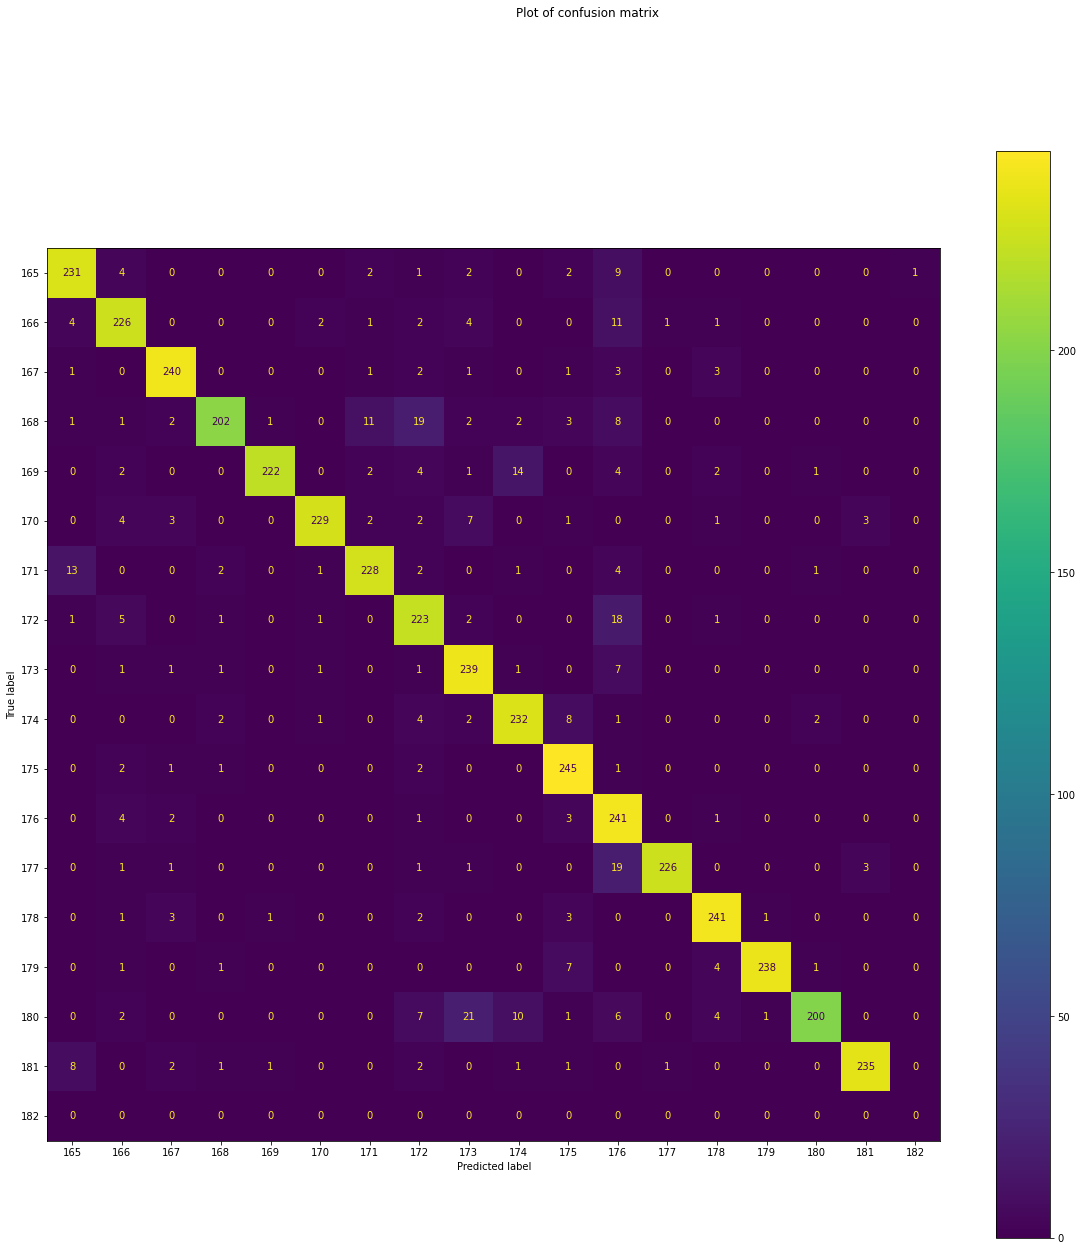

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display = ConfusionMatrixDisplay.from_predictions(all_classes, predicted_classes)
fig = display.figure_
fig.set_figwidth(20)
fig.set_figheight(20) 
fig.suptitle('Plot of confusion matrix')